In [6]:
import funclib as flib
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import string

Read original data

In [7]:
directory = "../../scripts/alphas"

taxa = ["Mammals.Homo_sapiens", "Birds.Gallus_gallus", "Snakes.Thamnophis_elegans"]

og_data = pd.DataFrame()
for taxon in taxa:
    df = pd.read_csv("{}/{}.LM.tsv".format(directory, taxon),sep="\t")
    df["Taxon"] = taxon.split(".")[0]
    og_data = pd.concat([og_data, df])
    
og_data["source"] = "original"

palette = pd.read_csv("../../data/plot_colors.tsv",sep="\t").set_index("Order")["Color"].to_dict()

Taxa and other sources, in the same order

In [8]:
sources = {"LM":"Mammals.Mus_musculus", 
           "mean":"Mammals.Homo_sapiens,Birds.Gallus_gallus,Snakes.Thamnophis_elegans", 
           "mean_of_ratios":"Mammals.Homo_sapiens",
           "LM.CpGOut":"Mammals.Homo_sapiens,Birds.Gallus_gallus,Snakes.Thamnophis_elegans",
           "LM.phastcons":"Mammals.Homo_sapiens,Birds.Gallus_gallus",
           "with_reptime.LM":"Mammals.Homo_sapiens", 
           "LM.microchroms-included":"Birds.Gallus_gallus,Snakes.Thamnophis_elegans"}
names = {"LM":"reference_seq",
         "mean":"without_regression",
         "mean_of_ratios":"mean_ratios",
         "LM.CpGOut":"CpG_masked",
         "LM.phastcons":"phastcons",
         "with_reptime.LM":"RT_included",
         "LM.microchroms-included":"micro_included"
        }

Pair original alphas with conditions

In [9]:
# Mutation type
mut_type = "mod"
alpha_vars = ["alpha","alpha_lwr","alpha_upr"]

# Read data
comparisons_df = pd.DataFrame()

for source,taxa in sources.items():

    data = pd.DataFrame()
    for taxon in taxa.split(","):
        df = pd.read_csv("{}/{}.{}.tsv".format(directory, taxon, source),sep="\t")
        if source=="mean":
            df = df[df.weighted_mean==True]
        if source=="mean_of_ratios":
            df = df[df.gc_width==0.03]
        group = taxon.split(".")[0]
        df["Taxon"] = group
        data = pd.concat([data, df])
    
        
    # Pair with original dataset
    og_data_2pair = og_data[(og_data.mut_type==mut_type) & (og_data.Taxon.isin(data.Taxon.unique()))].set_index("species")[alpha_vars]
    data_2pair = data[(data.mut_type==mut_type)].set_index("species")[alpha_vars + ["Taxon"]]
    paired_data = og_data_2pair.join(data_2pair, lsuffix=".original").reset_index()
    paired_data["condition"] = names[source]          
        
    # Add to df
    comparisons_df = pd.concat([comparisons_df, paired_data])
    
    # Special case, phastcons + gBGC-unaffected
    if source=="LM.phastcons":
        data_2pair = data[(data.mut_type=='gc-BGC-unaffected')].set_index("species")[alpha_vars + ["Taxon"]]
        paired_data = og_data_2pair.join(data_2pair, lsuffix=".original").reset_index()
        paired_data = og_data_2pair.join(data_2pair, lsuffix=".original").reset_index()
        paired_data["condition"] = names[source] + "_gBGCunaffected"
        comparisons_df = pd.concat([comparisons_df, paired_data])
        
# gBGC
paired_data = og_data[og_data.mut_type=="gc-BGC-unaffected"].set_index("species")[alpha_vars].join(og_data[og_data.mut_type=="mod"].set_index("species")[alpha_vars], rsuffix=".original").reset_index()
paired_data["condition"] = "gBGC_unaffected"
paired_data["Taxon"] = og_data[og_data.mut_type=="mod"].Taxon.values
comparisons_df = pd.concat([comparisons_df, paired_data])

DNM data, to include if needed

In [10]:
selected_species = ["Mus_musculus"]
dnms = pd.read_csv("{}/dnm_est_mutrate.tsv".format(directory.replace("scripts/alphas","data")),sep="\t")
dnms["Species"] = ["_".join(sp.split()[:2]) for sp in dnms.Species]

subd_dnms = dnms[dnms.Species.isin(selected_species)]
dnm_alpha = {}
for sp,df in subd_dnms.groupby("Species"):
    p = df["Pat DNMs"].sum()
    m = df["Mat DNMs"].sum()
    dnm_alpha[sp] = p/m

Generate plot

In [17]:
condition_labels = {"reference_seq": "Changing reference sequence",
                    "CpG_masked": "Excluding CpG sites",
                    "phastcons": "Excluding conserved sites",
                    "RT_included": "Including replication timing",
                    "without_regression": "Using mean substitution rates", 
                    "mean_ratios": "Using mean of X-to-autosome ratios", 
                    "micro_included": "Including microchromosomes",
                    "gBGC_unaffected":"Excluding sites affected by gBGC",
                    "phastcons_gBGCunaffected":"Excluding conserved sites &\nthose affected by gBGC"}
condition_order = ['reference_seq', 'RT_included', 'without_regression', 'mean_ratios', 'CpG_masked', 'phastcons','gBGC_unaffected','phastcons_gBGCunaffected','micro_included']

Add mean of original condition as label

In [18]:
original_means = comparisons_df[comparisons_df.condition=="without_regression"].groupby("Taxon")["alpha.original"].mean().to_dict()
comparisons_df["Taxon_mean"] = (["{} ({:.2f})".format(r.Taxon, original_means[r.Taxon]) for i,r in comparisons_df.iterrows()])
hue_order = ["{} ({:.2f})".format(taxon, original_means[taxon]) for taxon in ["Birds", "Mammals", "Snakes"]]

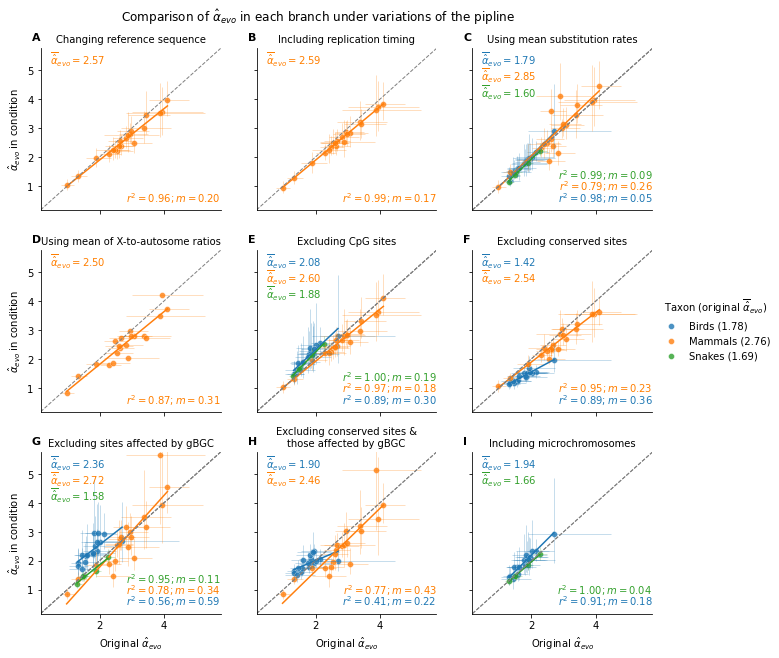

In [29]:
axes_limit = [0.17, 5.75]

g = sns.FacetGrid(data=comparisons_df, col="condition", col_wrap=3, col_order=condition_order,
                  hue="Taxon_mean", hue_order=hue_order, legend_out=True)

g.map(sns.scatterplot, "alpha.original", "alpha", alpha=0.8)
g.map(sns.regplot, "alpha.original", "alpha", scatter=False, line_kws={"linewidth":1.5}, label="", ci=None)
g.map(flib.identity_line, color="gray", linewidth=1, label="")

g.fig.subplots_adjust(top=0.915) # adjust the Figure in rp
g.fig.suptitle(r'Comparison of $\hat{\alpha}_{evo}$ in each branch under variations of the pipline',x=0.4, fontsize=12)

g.set_axis_labels(r"Original $\hat{\alpha}_{evo}$", r"$\hat{\alpha}_{evo}$ in condition")
g.add_legend(title=r"Taxon (original $\overline{\hat{\alpha}}_{evo}$)")

for iletter,(condition, ax) in enumerate(g.axes_dict.items()):
    
    cond_df = comparisons_df[comparisons_df.condition==condition]
    
    # CIs
    ax.hlines(y=cond_df.alpha, xmin=cond_df["alpha_lwr.original"], xmax=cond_df["alpha_upr.original"], 
              linewidth=0.5, zorder=1, color=[palette[t] for t in cond_df.Taxon], alpha=0.5)
    if condition!="mean_ratios":
        ax.vlines(x=cond_df["alpha.original"], ymin=cond_df["alpha_lwr"], ymax=cond_df["alpha_upr"], 
                  linewidth=0.5, zorder=1, color=[palette[t] for t in cond_df.Taxon], alpha=0.5)
    
    # Annotate stats per taxon
    for i,(taxon,subd) in enumerate(cond_df.groupby("Taxon")):

        # Correlation coefficients & MAE
        r, pval = pearsonr(subd["alpha"], subd["alpha.original"])
        mae = mean_absolute_error(subd["alpha"], subd["alpha.original"])
        ax.text(1, 0.05+(i*0.07), r"$r^2={:.2f}; m={:.2f}$".format(r**2,mae), transform=ax.transAxes,color=palette[taxon],ha="right")
        ax.set_title(condition_labels[condition], fontsize=10)

        # Mean alphas
        x_text = axes_limit[0]*2
        y_text = axes_limit[-1]*0.7+(0.5*i)
        mean_condition = subd["alpha"].mean()
        mean_original = subd["alpha.original"].mean()
        ax.text(0.05, 0.9-(i*0.1), r"$\overline{\hat{\alpha}}_{evo}=$"+"{:.2f}".format(mean_condition), 
                transform=ax.transAxes,color=palette[taxon])
        
    
    # Mouse DNMs
    #if condition=="without_regression":
    #    xa_dict = cond_df.set_index("species")[["alpha", "alpha.original"]].to_dict()
    #    for sp in selected_species:
    #        x = xa_dict["alpha.original"][sp]
    #        y = xa_dict["alpha"][sp]
    #        dnm_a = dnm_alpha[sp]
    #        ax.scatter(x, y, color="none", edgecolor="black",zorder=10)
    #        ax.scatter(dnm_a, dnm_a, color="gray", s=10, zorder=25)
    #        ax.plot([x, dnm_a],[y,dnm_a],
    #                zorder=0, linewidth=1, color="gray")
    #        ax.annotate("Mouse", xy=(x*1.05,y), ha="left", va="top", fontsize=10)
            
    # Letter panel
    ax.text(-0.05, 1.05, string.ascii_uppercase[iletter], transform=ax.transAxes, 
            size=11, weight="bold")
            
    # Limits for axes
    ax.set_xlim(axes_limit)
    ax.set_ylim(axes_limit)
        
#plt.tight_layout()
#plt.show()
plt.subplots_adjust(hspace=0.25,wspace=0.2)
plt.savefig("../pdfs/Figure_SX_conditions_alpha_CIs_meanalphas_phastcons_gBGCunaff_MAE.pdf", bbox_inches = 'tight')

Pairwise comparisons configurations of exon & phastcons

In [29]:
file_names = {"exon_phastcons_lcase.LM":"exons_phastcons",
              "LM":"exons1kb",
              "LM.phastcons":"exons1kb_phastcons"}

taxon = ["Mammals.Homo_sapiens","Birds.Gallus_gallus"]
directory = "../../scripts/alphas"

merged_df = pd.DataFrame()

for suff,filter_name in file_names.items():

    for tax in taxon:
        
        df = pd.read_csv("{}/{}.{}.tsv".format(directory, tax, suff),sep="\t")
        df["filtered"] = filter_name
        df["taxon"] = tax.split(".")[0]
        merged_df = pd.concat([merged_df, df])

In [91]:
merged_df["ci"] = merged_df.alpha_upr-merged_df.alpha_lwr

Plot combinations for all subsitutions

In [95]:
pivot_df = merged_df.pivot(index=["species","mut_type","taxon"], columns="filtered",values="alpha").reset_index()

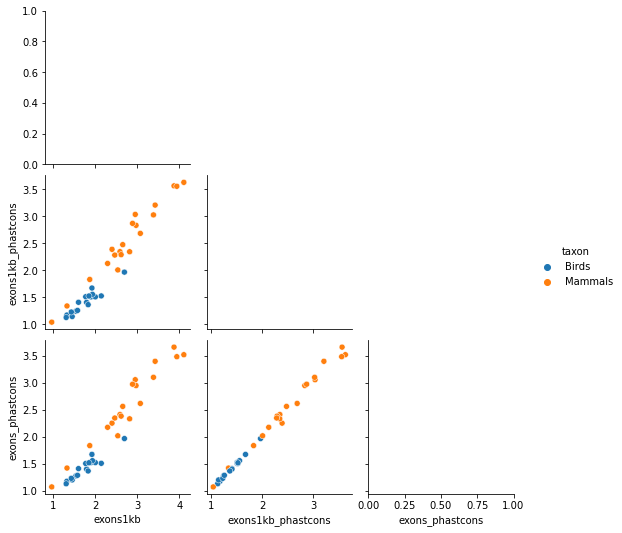

In [101]:
g = sns.pairplot(data=pivot_df[pivot_df.mut_type=="mod"],hue="taxon",diag_kind="None", corner=True)
#for i,ax in enumerate(g.axes.flatten()):
#    if i in [3,6,7]:
#        flib.identity_line(ax=ax,color="gray",linewidth=1)
#        ax.set_xlim([0.5,4.5])
#        ax.set_ylim([0.5,4.5])
#plt.tight_layout()
#plt.savefig("../pdfs/exons_phastcons_combinations.pdf")